In [9]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

In [5]:
# setting up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
# This is the most critical part of any time-series project. The data needs to be fetched, scaled, and structured into "sequences" that the LSTM can understand.

# downloading apple stock data
ticker = 'AAPL'
data = yf.download(ticker, start='2015-01-01', end='2024-12-31')

# using only close prices
close_price = data[['Close']]

/tmp/ipython-input-3095151230.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2015-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


In [16]:
# normalizing the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_prices = scaler.fit_transform(close_price)

In [17]:
# lstm predicts on previous data
# creating sequence in which first 60 days will work as data and we will prefict price at 61st day
def create_sequence(data, seq_length):
  xs, ys = [], []
  for i in range(len(data) - seq_length):
    x=data[i:i+seq_length]
    y=data[i+seq_length]
    xs.append(x)
    ys.append(y)
  return np.array(xs), np.array(ys)
seq_length = 60
X, y = create_sequence(scaled_prices, seq_length)

In [24]:
# splitting the data and coverting to tensors
train_size = int(len(X)*0.8)
test_size = len(X) - train_size

In [25]:
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# converting them to pytorch tensors, and also moving data to gpu
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

In [28]:
X_test.shape

torch.Size([491, 60, 1])

In [29]:
# defining the LSTM model
class StockLSTM(nn.Module):
  def __init__(self, input_size=1, hidden_layer_size=50, num_layers=2, output_size=1):
    super().__init__()
    self.hidden_layer_size = hidden_layer_size
    self.num_layers = num_layers

    # lstm layer
    self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)

    self.linear = nn.Linear(hidden_layer_size, output_size)

  def forward(self, input_seq):
    # Initialize hidden and cell states
    h0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).to(device)
    c0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).to(device)

    # We need to pass in the hidden and cell states into the model
    lstm_out, _ = self.lstm(input_seq, (h0, c0))

    # output of lasttime stamp is only required
    predictions = self.linear(lstm_out[:, -1, :])
    return predictions

# instantiate the model
model = StockLSTM().to(device)

In [31]:
# parameter and loss functions
learning_rate = 0.001
epochs = 25

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
# traing the model

for epoch in range(epochs):
  model.train()

  # forward Pass
  outputs = model(X_train)

  # calculate loss
  optimizer.zero_grad()
  loss = loss_function(outputs, y_train)

  # backward pass and optimization
  loss.backward()
  optimizer.step()

  if (epoch+1) % 5 == 0:
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

Epoch [5/25], Loss: 0.049180
Epoch [10/25], Loss: 0.040757
Epoch [15/25], Loss: 0.039951
Epoch [20/25], Loss: 0.036022
Epoch [25/25], Loss: 0.034440


In [33]:
model.eval()

StockLSTM(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

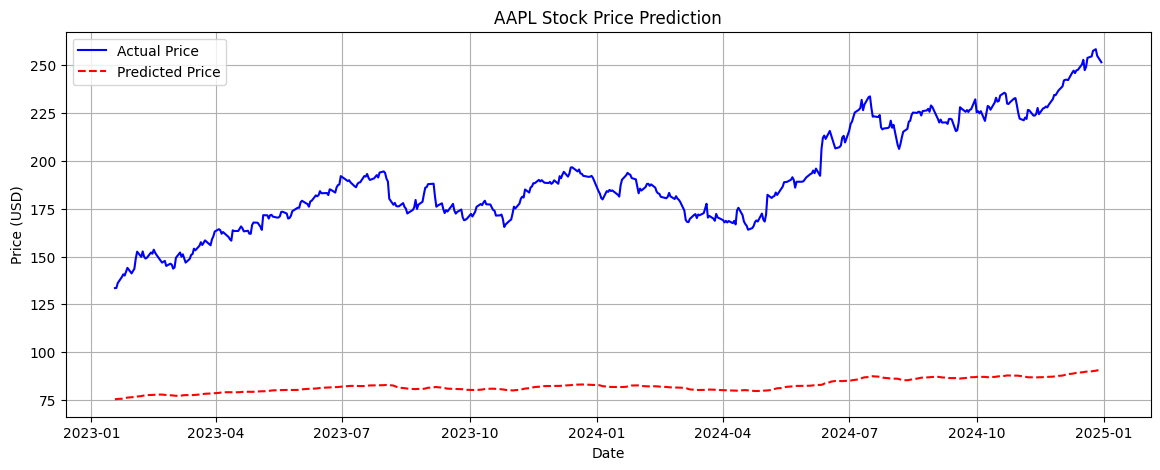

In [35]:
with torch.no_grad():
  test_predictions = model(X_test)

# Inverse transform the predictions and actuals to get real stock prices
test_predictions = scaler.inverse_transform(test_predictions.cpu().numpy())
y_test_actual = scaler.inverse_transform(y_test.cpu().numpy())

# Get the dates for the test set for plotting
test_dates = close_price.index[train_size+seq_length:]

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_test_actual, color='blue', label='Actual Price')
plt.plot(test_dates, test_predictions, color='red', linestyle='--', label='Predicted Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()